## RFM & Cohort Analysis
This dataset contains all the transactions occurred for a year for a UK-based worldwide online retail shop, with customers from 30+ countries. Many customers of the company are wholesalers. Based off the business character, I believe it worth to take a closer look at the fluctuations of sales trend throughout the year. Thus I am going to conduct a marketing analysis which includes key performance index (KPI) check and RFM analysis in order to understand the business in a broad perspective as well as to get action plan ideas. 

### Table of Contents
1. Data preprocessing
2. KPI check as a whole 
3. KPI check in cohort groups
4. Customer Segmentation with RFM
5. K-means Clustering
6. Conclusion

### Data Preprocessing

In [121]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
import squarify
import re
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [122]:
df = pd.read_csv("data.csv")

In [123]:
# checking for duplicated rows 

df.drop_duplicates(inplace = True)

In [124]:
# missing data

df.dropna(subset = ['CustomerID'], inplace = True) # drop all missing IDs, since RFM analysis only can be performed with data categorized with ID. 
df['Description'].fillna('NO DATA', inplace = True)
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [125]:
# UnitPrice -> TotalPrice

df['TotalPrice'] = df['UnitPrice']*df['Quantity']
df.head()

# I usually remove outliers using IQR method at this stage, but this time I am going to leave them here since later on I would like to understand customers in all spending levels.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom,20.34


In [126]:
df_order = df.copy()
df_order.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom,20.34


In [127]:
df_order['CustomerID'] = df_order['CustomerID'].astype(int).astype(str)
df_order['Country'] = df_order['Country'].astype('category')
df_order['InvoiceDate'] = pd.to_datetime(df_order['InvoiceDate'])
df_order['InvoiceMonth'] = df_order['InvoiceDate'].dt.to_period('m')
df_order['InvoiceDay'] = df_order['InvoiceDate'].dt.to_period('d')

### 2. KPI analysis

#### 0) Before We Start

In [128]:
df.Country.value_counts().head(10)

United Kingdom    356728
Germany             9480
France              8475
EIRE                7475
Spain               2528
Netherlands         2371
Belgium             2069
Switzerland         1877
Portugal            1471
Australia           1258
Name: Country, dtype: int64

Let's first check which country our customers are from - we can easily see that the vast majority of customers are from the United Kingdom. So I am going to analyse the trend based on public holidays in the United Kingdom first, and then the common holidays in Europe area. 

It's not always the best idea to list all KPIs available, as we only have limited resources and therefore we are not able to improve all indexes at the same time. Therefore I am only focusing the following KPIs, including Monthly Order Count, Total Basket Size (=Monthly Revenue) and Average Revenue per Customer for the New , Existing customer group each.

#### 1) Monthly Revenue (Total Basket Size)

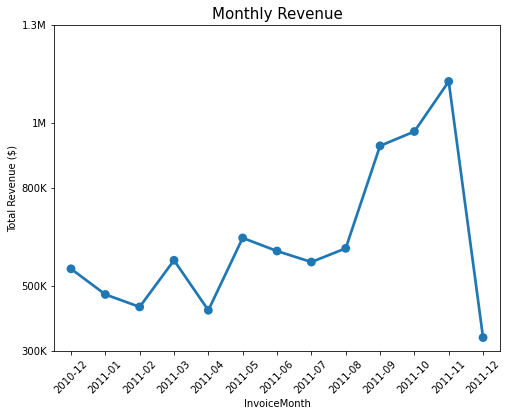

In [129]:
df_month = df_order.groupby(['InvoiceMonth'])['TotalPrice'].sum().reset_index()

plt.figure(figsize = (8,6))
sns.pointplot(data = df_month, x = 'InvoiceMonth', y = 'TotalPrice')
plt.xticks(rotation = 45)
plt.yticks([300000, 500000, 800000, 1000000, 1300000], labels = ['300K','500K', '800K','1M', '1.3M'])
plt.ylabel("Total Revenue ($)")
plt.title('Monthly Revenue', size = 15);

- Revenue increase a month BEFORE two biggest holidays (April for Easter and December for Christmas). However significant drop at the months of holidays.
- Customers are highly likely to start to prepare for gifts a month ahead of the holidays - probably that is the reason of the increase
- The drop is because of low demand of shopping due to shopping debt after the big holidays.


- Revenue is usually higher in 2nd half of the year. Considering the revenue remains high for the whole quarter, it seems we had a marketing promotion going on since Sep 2011.
- The holiday debt explains the huge decrease in Dec 2011 as well. Even though we have only collected data until 9 Dec 2011, the monthly revenue is predicted to be less than $ 1M.


- The reason of revenue increase in May 2011 is considered as a weather, especially the sunshine. Researches show that in the spring and summer, where the sunshine is more likely, the chance for sales increases. This could partly account for the increase in Mar 2011, when the spring begins in general.

In [130]:
# # Monthly Revenue change

# df_month = df_order.groupby(['InvoiceMonth'])['TotalPrice'].sum().reset_index()
# df_month['Change'] = df_month['TotalPrice'].pct_change()

# plt.figure(figsize = (8,6))
# sns.pointplot(data = df_month, x = 'InvoiceMonth', y = 'Change')
# plt.xticks(rotation = 45)
# plt.ylabel("Growth Rate (%)")
# plt.axhline(y = 0, linestyle = '--')
# plt.title('Monthly Revenue Change', size = 15);

# - As we have seen previously, high growth rate is likely to occur when 1) season changes to spring / summer 2) there is a big holiday when people buys present for their family.
# - In a nutshell, these two variables drive customers' shopping demand throughout the year.

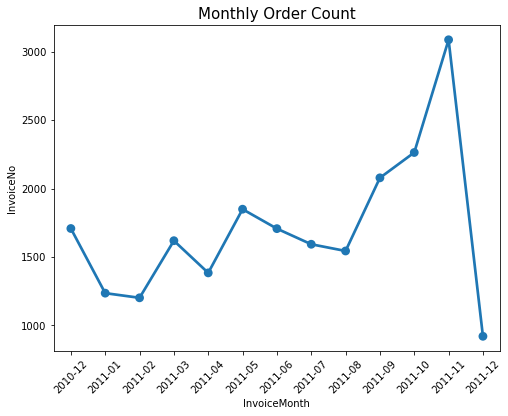

In [131]:
# monthly order count

df_monthly_sales = df_order.groupby('InvoiceMonth')['InvoiceNo'].nunique().reset_index()
plt.figure(figsize = (8,6))
sns.pointplot(data = df_monthly_sales, x = 'InvoiceMonth', y = 'InvoiceNo')
plt.title('Monthly Order Count', size = 15)
plt.xticks(rotation =45);

- The Monthly Active Customers in Sep 2011 has increased by 30% and showed consecutive increase until Nov 2011. Given that the number is quite high and long lasting, even for holidays demands, it seems this company has been holding a campaign since the end of Q3 2011.
- Apr/ Oct (& Nov) 2011 have higher Monthly Active Customers, compare to revenue increasement. This obviously mean that people tend to spend less than they usually do. Then the next question is, who exactly spent less- new customers or existing customers?
- Two hypothesises for this; Hypothesis 1) There was a surge of new customers who tend to spend less.  
- Hypothesis 2) Existing customers dind't buy as much as they usually do. We are going to check these assumptions.

): 구매 금액 적은 새 인원 유입.(이건 사실 아님) 가설2) 기존 인원이 평소보다 안샀따. 이따 검증해보자.


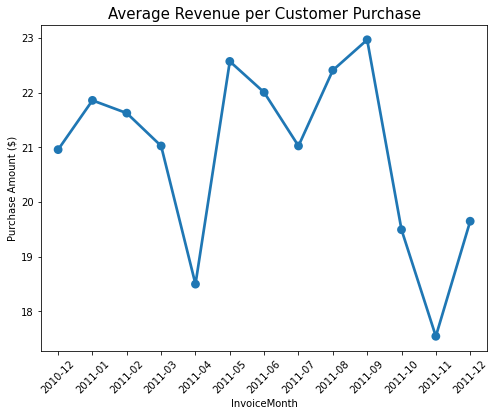

In [132]:
# Average revenue per customer purchase

df_monthly_order_avg = df_order.groupby('InvoiceMonth')['TotalPrice'].mean().reset_index()
plt.figure(figsize = (8,6))
sns.pointplot(data = df_monthly_order_avg, x = 'InvoiceMonth', y = 'TotalPrice')
plt.xticks(rotation = 45)
plt.title('Average Revenue per Customer Purchase', size = 15)
plt.ylabel("Purchase Amount ($)");

- We have faced the 1st low season of 2011 in Jan and Feb due to seasonality. (holiday effect and winter) We can assume that those who shop during this low season must not care about the seasonality that much and like shopping quite a lot, and that explains the average spending. Since they are the genuine shopping lovers, we can target them by analysing the highest sold categories and throwing promotions for the items.
- We have already witnessed that Monthly Active Users and Monthly Revenue in April was significantly low, probably because of holiday effect after Easter. However, unlike Jan and Feb, the average revenue per customer is nearly the lowest in the year. It seems April is lowest fall throughout the year. We should start promotions for daily necessities, in order to attract 
- Average revenue has risen up in May. May is the month where most stores start promiting new items for Summer. That probably increased users' purchase amount who are excited about the new season. 
- When the year end promotion first started in Sep the average spending was very high. However, as the promotion continues the average spending got even lower than usual, because of inflow of users who didn't buy much. We should measure the cost effectiveness of the promotion and decide whether to continue or not.

In [133]:
# df_order.groupby(['InvoiceMonth'])['TotalPrice'].agg(['mean', 'max'])

- 11월에 합계 금액은 가장 많은데 인당 구매 금액은 가장 낮다. 가설: 기존 고객은 원래대로 쓰고 있는데 신규 고객이 많이 들어와서 얼마 안산 것. 이따 검증해보자.
- 1월 합계 금액은 가장 적은데 인당 구매 금액은 가장 높다. 사람들이 
- 4월은 합계 금액도 제일 적은데 인당 구매 금액 역시 낮다. 이때는 신규 고객 유입을 늘리고 소비를 늘리는 마케팅이 필요하다!
- 5월은 합계 금액대비 인당 구매 금액이 가장 많다.ㅇ 

In [134]:
# Monthly New user growth

df_min_purchase = df_order.groupby('CustomerID').InvoiceMonth.min().reset_index()
df_min_purchase.columns = ['CustomerID','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

df_order = pd.merge(df_order, df_min_purchase, on='CustomerID')
df_order['usertype'] = 'New'
df_order['month_y'] = df_order['InvoiceMonth'].map(lambda date: 100*date.year + date.month)
df_order.loc[df_order['month_y']>df_order['minpurchasedate'],'usertype'] = 'Existing'

df_user_type_revenue = df_order.groupby(['month_y','usertype', 'InvoiceMonth'])['TotalPrice'].sum().reset_index()
df_user_type_revenue

,month_y,usertype,InvoiceMonth,TotalPrice
0,201012,New,2010-12,552372.86
1,201101,Existing,2011-01,271081.05
2,201101,New,2011-01,202650.85
3,201102,Existing,2011-02,286428.67
4,201102,New,2011-02,149105.40
5,201103,Existing,2011-03,389087.82
6,201103,New,2011-03,189488.39
7,201104,Existing,2011-04,305660.86
8,201104,New,2011-04,119561.81
9,201105,Existing,2011-05,531517.41


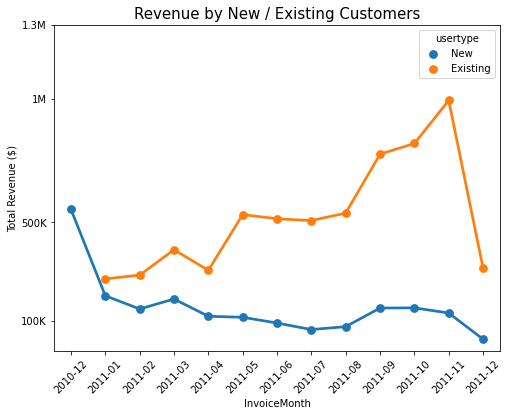

In [135]:
plt.figure(figsize = (8,6))
sns.pointplot(hue = 'usertype', data = df_user_type_revenue, x = 'InvoiceMonth', y = 'TotalPrice')
plt.xticks(rotation = 45)
plt.yticks([100000, 500000, 1000000, 1300000], labels = ['100K', '500K', '1M', '1.3M'])
plt.ylabel("Total Revenue ($)")
plt.title('Revenue by New / Existing Customers', size = 15);

- In terms of total revenue by new / existing customers, we can conclude that our campaign was successful again
- Just like more existing users came back to the app than new customers, they spent more - we can verify again that the campaign was more attractive to existing users. Since the impact of campaign was limited for the new users, existing customers' spending dominates the whole revenue trend.


- Then how do the new customers find the campaign? If we have more data (e.g. customer review, activity log...) we will be able to get more insight.

Do the increase in 'total' order count and 'total' spending amount necessarily mean a successful campaign? Let's dig in it further in the next plots.

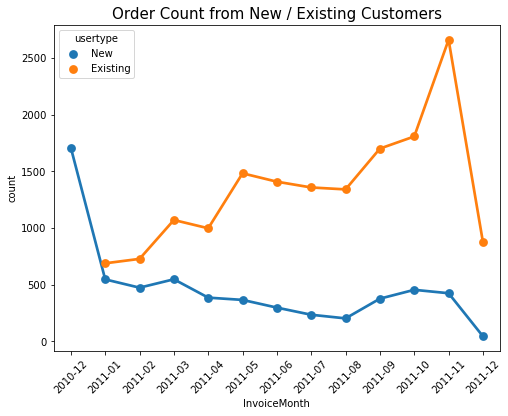

In [136]:
# New customer ratio

new_old = df_order.groupby(['InvoiceMonth','usertype'])['InvoiceNo'].nunique().reset_index(name = 'count')
plt.figure(figsize = (8,6))
sns.pointplot(data = new_old, x = 'InvoiceMonth', y = 'count', hue = 'usertype')
plt.xticks(rotation = 45)
plt.title("Order Count from New / Existing Customers", size = 15);

- In Sep 2011, the new customers have increased swimming against the trend, and more existing customers came back - This is probably the effect of marketing campaign thrown for new & existing customers both.
- However, the number of new customers hasn't reached the level at the beginning of the year, even after the campaign. 
- I'm concerned about the consecutive drop of new users since Apr 2011, when existing users continued to grow. Maybe we should check with other team what has caused low purchase rate of new users, as this could limit the effect of campaign.
- In terms of the number of active users, we can say that the campaign was successful because it certainly grew.

- It seems the marketing was more effective to existing users, based on the order count.

- 하지만 신규고객의 경우 마케팅을 해도 올 초 MAU 낮았을 때의 수준도 회복하지 못하고 있다. 잘못된 타겟에게 마케팅을 한 경우로 보임. 마케팅 대상을 다시 검토해봐야.

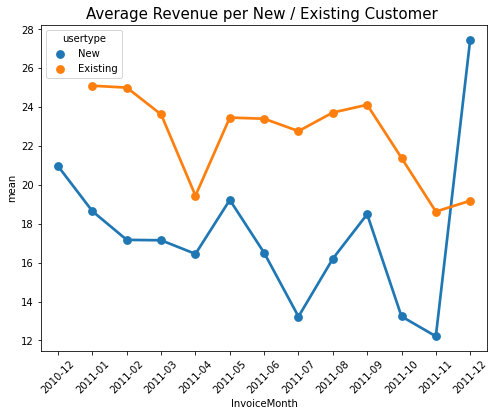

In [137]:
new_old = df_order.groupby(['InvoiceMonth', 'usertype'])['TotalPrice'].mean().reset_index(name = 'mean')
plt.figure(figsize = (8,6))
sns.pointplot(data = new_old, x = 'InvoiceMonth', y = 'mean', hue = 'usertype')
plt.xticks(rotation = 45)
plt.title("Average Revenue per New / Existing Customer ", size =15);

- Average spending per person decreased since Oct 2011 in both group, as not everyone purchased more than certain amount. Probably many of the users purchased minimum spending amount to get a benefit of promotion (or only purchased really low amount for trial), which is common during the promotion period. We will have to track if theses users come back in the next months. 
- We have already witnessed that the revenue decreases in April and July. This trend is just the same to both type of users.
- The soar of new customers mean spending in Dec 2012 is because there are few incoming customers. 
- Existing individual customers spend more than new individual customers, which is why it's more important to maintain current customers than gathering new users.


- In order to decide whether the campaign was successful or not, we will have to track in the next few months 1) if the users who enjoyed the benefit would come back and 2) if average spending amount increases after holiday debt.

In [138]:
# 10,11월 가설 검증 - 매월 맥시멈 인당 주문건수

# df_1 = df_order.groupby(['InvoiceMonth', 'CustomerID'])['InvoiceNo'].count().reset_index(name = 'count')
# df_1.groupby('InvoiceMonth')['count'].max()

In [139]:
# df_1[(df_1['InvoiceMonth']=='2011-10') | (df_1['InvoiceMonth']=='2011-11')| (df_1['InvoiceMonth']=='2011-04')| (df_1['InvoiceMonth']=='2011-07')].groupby(['InvoiceMonth', 'CustomerID'])['count'].sum().sort_values(ascending=False).head(20)

In [140]:
# df_order[(df_order['CustomerID']=='14096')].InvoiceDate.unique()
# 10,11월 둘 다 같은 회원번호고, 지속적으로 구매하고 있다. we can't lose this customer. 이런 사람은 priviliged perks등을 제공해줘서 계속 남아있게 해야.

In [141]:
# total refund

# df_negative = df_order[df_order['TotalPrice']<0]
# df_negative_month = df_negative.groupby(['InvoiceMonth'])['TotalPrice'].sum().reset_index()
# plt.figure(figsize = (8,6))
# sns.pointplot(data = df_negative_month, x = 'InvoiceMonth', y = 'TotalPrice')

# plt.xticks(rotation = 45)
# plt.yticks([-200000, -100000, -50000, 0], labels = ['-200K','-100K', '-50K',0])
# plt.ylabel("Total Revenue ($)")
# plt.title('Monthly Refund', size = 15);

- I'm concerned about the refund cases greater than $ 50K in Jan / Jun/ Oct / Dec 2011. Let's take a closer look into those transactions and see what exactly happened.

In [142]:
# df_negative[(df_negative['InvoiceMonth']=='2011-01')|(df_negative['InvoiceMonth']=='2011-06')|
#             (df_negative['InvoiceMonth']=='2011-10')|(df_negative['InvoiceMonth']=='2011-12')][['InvoiceMonth','CustomerID', 'TotalPrice']].sort_values(by = 'TotalPrice').head(20)
# - It seems most of cases in Jan / Jun / Dec 2011 are mostly from one or few customers. Since the refund issue is not about many customers, I don't find this problematic.
# - In contrast, we can see the cases in Oct 2020 are from multiple people. It is very likely that there were something that could trigger customers to cancel their purchase with us, which is serious. We need to check with Sales team / Customer Service team whether there were any feedback from users around that period.

### 3. KPI Analysis (Cohort)

In [143]:
cohort = df_order.copy()

In [144]:
cohort['CohortMonth'] = cohort.groupby('CustomerID')['InvoiceMonth'].transform('min')

months = ['InvoiceMonth', 'CohortMonth']
for i in months:
    cohort[i] = cohort[i].dt.to_timestamp()
    
year_diff = cohort['InvoiceMonth'].dt.year - cohort['CohortMonth'].dt.year
month_diff = cohort['InvoiceMonth'].dt.month - cohort['CohortMonth'].dt.month
cohort['Months'] = year_diff*12 + month_diff + 1

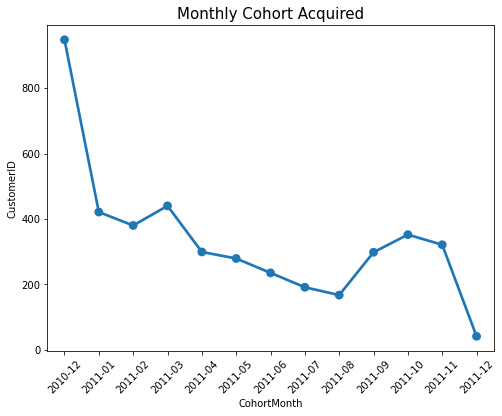

In [145]:
cohort_table = cohort.groupby(['CohortMonth', 'Months'])['CustomerID'].agg('nunique').reset_index()
cohort_table_1 = cohort_table[cohort_table['Months'] == 1]
cohort_table_1['CohortMonth'] = cohort_table_1['CohortMonth'].dt.to_period("m")

plt.figure(figsize = (8,6))
sns.pointplot(data = cohort_table_1, x = 'CohortMonth', y = 'CustomerID')
plt.xticks(rotation = 45)
plt.title("Monthly Cohort Acquired", size = 15);

It looks like a promotion was going on until Mar 2011. However the new user count acquired decreased after the protion ends, until we start another promotion for Sep 2011. The promotion, unfortunately, didn't acquire as many as users we did at the beginning of the year. Did people not find the promotion not attractive? Did we target the wrong group of people? 

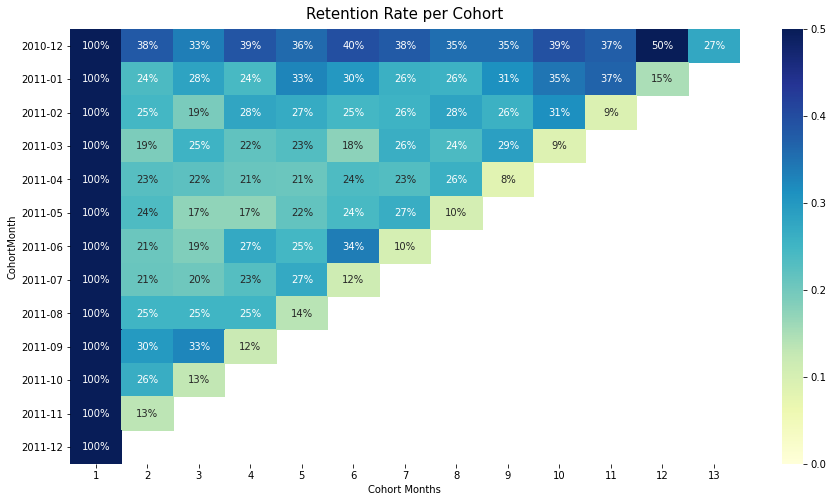

In [146]:
# Retention table

cohort_count = pd.pivot_table(index = "CohortMonth", columns = "Months", values = "CustomerID", data = cohort_table)
calc_base = cohort_count.iloc[:,0]
retention = cohort_count.divide(calc_base, axis = 0)
retention.index = retention.index.strftime("%Y-%m")

plt.figure(figsize =(15,8))
sns.heatmap(data = retention, annot = True, fmt = '.0%', cmap = 'YlGnBu', vmin = 0.0,vmax = 0.5)
plt.title("Retention Rate per Cohort", size = 15, pad = 10)
plt.xlabel("Cohort Months");

- 9월에 마케팅 한 덕분에 신규유저 2011-09, 2011-10의 새 코호트가 늘어나고, 기존 유저들도 9월부터 리텐션이 늘어났다.
- 새 코호트는 지금으로는 리텐션이 fine 한 것 같은데 아직은 말하기 이르다. 더 지켜봐야.
- 하지만 여전히 가장 퀄리티가 좋은 유저는 2010년 12월 코호트고 그 다음이 2011-01 코호트. 시간이 가도 1/3 이상 유저가 살아있어 리텐션 높음.- 내년에 신규 마케팅할때는 얘네 타겟을 어떻게 잡았는지 꼭 참고하도록
- 반면 가장 안좋은 퀄리티는 프로모션 끝나고 4,5,6,7월에 들어온 애들. 그래서 9월에 마케팅 하려고 했겠지.


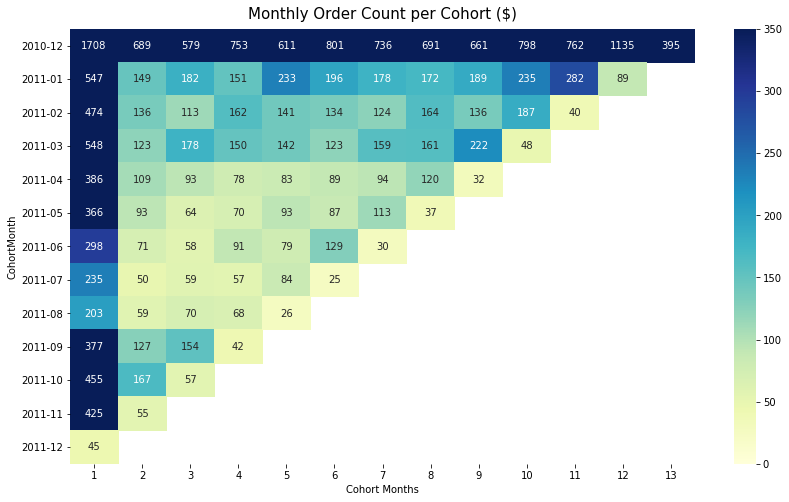

In [147]:
cohort_user = cohort.groupby(['CohortMonth', 'Months'])['InvoiceNo'].nunique().reset_index()
cohort_user_1 = pd.pivot_table(data = cohort_user, index = "CohortMonth", columns = "Months", aggfunc = 'sum', values = "InvoiceNo")
cohort_user_1.index = cohort_user_1.index.strftime('%Y-%m')
cohort_user_1 = round(cohort_user_1,1)

plt.figure(figsize = (14,8))
sns.heatmap(data = cohort_user_1, annot = True, fmt = 'g', cmap = 'YlGnBu', vmin = 0, vmax =350)
plt.title("Monthly Order Count per Cohort ($)", size = 15, pad = 10)
plt.xlabel("Cohort Months");

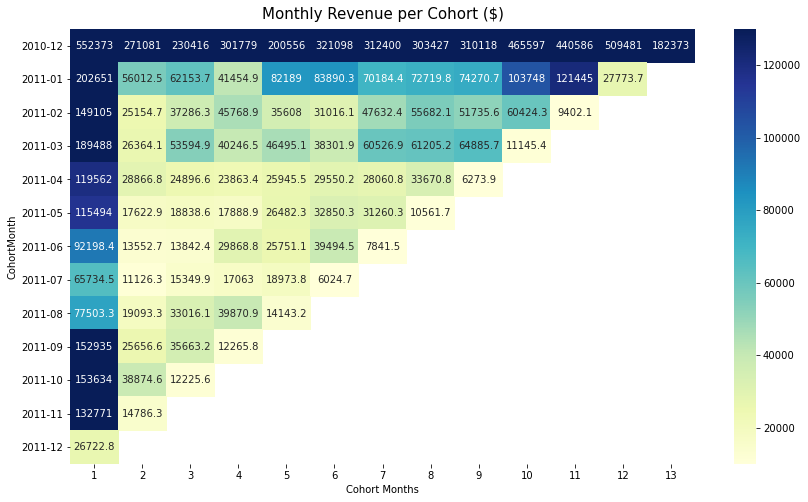

In [148]:
cohort_basket = cohort.groupby(['CohortMonth', 'Months'])['TotalPrice'].sum().reset_index()
cohort_basket_1 = pd.pivot_table(data = cohort_basket, index = "CohortMonth", columns = "Months", aggfunc = 'sum', values = "TotalPrice")
cohort_basket_1.index = cohort_basket_1.index.strftime('%Y-%m')
cohort_basket_1 = round(cohort_basket_1,1)

plt.figure(figsize = (14,8))
sns.heatmap(data = cohort_basket_1, annot = True, fmt = 'g', cmap = 'YlGnBu', vmin = 10000, vmax = 130000)
plt.title("Monthly Revenue per Cohort ($)", size = 15, pad = 10)
plt.xlabel("Cohort Months");

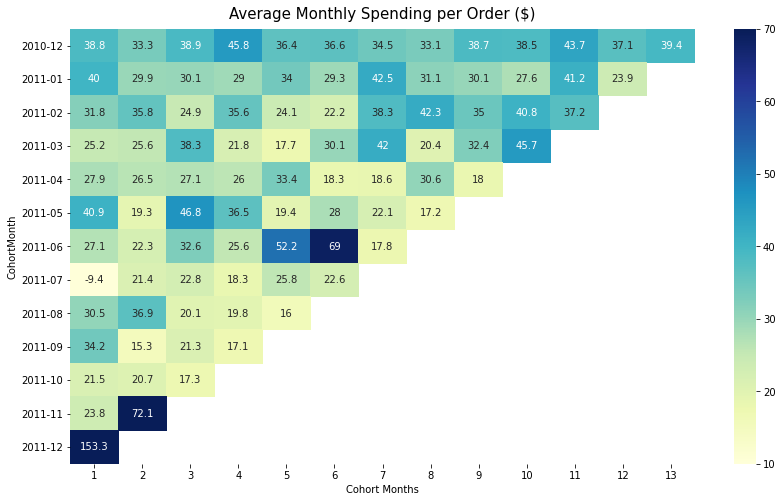

In [149]:
cohort['AvgAmt'] = cohort.groupby(['InvoiceMonth', 'Months','CustomerID'])['TotalPrice'].transform(np.mean)

# AvgAmt: average revenue by customer in each cohort & month 

cohort_avgamt = cohort.groupby(['CohortMonth', 'Months','CustomerID'])['AvgAmt'].mean().reset_index()
cohort_avgamt_1 = pd.pivot_table(data = cohort_avgamt, index = "CohortMonth", columns = "Months", aggfunc = 'mean', values = "AvgAmt")
cohort_avgamt_1.index = cohort_avgamt_1.index.strftime('%Y-%m')
cohort_avgamt_1 = round(cohort_avgamt_1,1)

plt.figure(figsize = (14,8))
sns.heatmap(data = cohort_avgamt_1, annot = True, fmt = 'g', cmap = 'YlGnBu', vmin = 10, vmax = 70)
plt.title("Average Monthly Spending per Order ($)", size = 15, pad = 10)
plt.xlabel("Cohort Months");

평균이 더 높은 이유: 
1. 점수 높은 것이 주도할 경우 : 6월은 높은 편이지만 5월은 높지도 않음.
2. 전체적으로 높을 경우 : o
3. 낮은 것이 그리 낮지 않을 경우
6월달끼리 비교해야겠다.

In [150]:
cohort[cohort['InvoiceMonth'] == '2011-06'].groupby('Months')['AvgAmt'].agg(lambda x: x.sort_values(ascending = False).head().mean())

Months
1    430.14
2    296.38
3    143.04
4    287.42
5    159.19
6    242.00
7   1023.40
Name: AvgAmt, dtype: float64

2010월 12월, 2011월 1월 코호트가 유지율뿐만이 아니라 구매액도 높아 가장 건강한 코호트 입증.  고객 특성 맞는 사람들한테 마케팅이 잘됐다고 볼 수 밖에.
2011년 6월 5,6 코호트는 몇사람이 엄청 많이 산게 아니다. 전체적으로 많은 양을 구매한 것이다. 트렌드가 지속될 경우 얘네한테 6월 코호트한테 이때 뭐 한거 있는지 알아봐야 할 듯.
최근 모집한 코호트가 첫 코호트일때는 많은 금액을 구매했지만 시간이 갈수록 구매 금액이 프로모션 외 기간 수준으로 팍 떨어짐. 그렇게 건강하지는 않아 보임.

In [151]:
# 마이너스 코호트

pd.set_option('display.float_format', lambda x: '%.2f' % x)
cohort[cohort['Months']==1].groupby('InvoiceMonth')['AvgAmt'].agg(lambda x: x.sort_values().head().sum())

InvoiceMonth
2010-12-01   -1192.20
2011-01-01   -1279.60
2011-02-01    -161.46
2011-03-01    -585.85
2011-04-01     -15.48
2011-05-01     -17.00
2011-06-01     -11.55
2011-07-01   -6792.93
2011-08-01      10.33
2011-09-01      -2.95
2011-10-01    -134.80
2011-11-01       0.00
2011-12-01       0.00
Name: AvgAmt, dtype: float64

In [152]:
cohort[(cohort['InvoiceMonth'] == '2011-07') & (cohort['Months']==1)].query('AvgAmt < -100')

# CustomerID with negative total amount smaller than $-100

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,InvoiceDay,minpurchasedate,usertype,month_y,CohortMonth,Months,AvgAmt
339767,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448,United Kingdom,-4287.63,2011-07-01,2011-07-18,201107,New,201107,2011-07-01,1,-4287.63
339831,C560420,M,Manual,-1,2011-07-18 15:11:00,1592.49,15369,United Kingdom,-1592.49,2011-07-01,2011-07-18,201107,New,201107,2011-07-01,1,-1592.49
339832,C560430,M,Manual,-1,2011-07-18 15:21:00,611.86,13154,United Kingdom,-611.86,2011-07-01,2011-07-18,201107,New,201107,2011-07-01,1,-611.86
340172,C560572,M,Manual,-1,2011-07-19 14:45:00,112.35,17065,United Kingdom,-112.35,2011-07-01,2011-07-19,201107,New,201107,2011-07-01,1,-112.35
341255,C560645,M,Manual,-1,2011-07-20 11:23:00,451.42,15802,United Kingdom,-451.42,2011-07-01,2011-07-20,201107,New,201107,2011-07-01,1,-150.47
341256,560651,M,Manual,1,2011-07-20 11:38:00,451.42,15802,United Kingdom,451.42,2011-07-01,2011-07-20,201107,New,201107,2011-07-01,1,-150.47
341257,C560653,M,Manual,-1,2011-07-20 11:40:00,451.42,15802,United Kingdom,-451.42,2011-07-01,2011-07-20,201107,New,201107,2011-07-01,1,-150.47


In [153]:
cohort[(cohort['CustomerID'] == '15802')]
# 이 유저들은 구매 내역 없이 마이너스 내고 1년동안 다시 돌아오지 않음. 7월에 왜 이렇게 많은 것인가?????
# 관련 부서에게 물어ㅏㅂ보야.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,InvoiceDay,minpurchasedate,usertype,month_y,CohortMonth,Months,AvgAmt
341255,C560645,M,Manual,-1,2011-07-20 11:23:00,451.42,15802,United Kingdom,-451.42,2011-07-01,2011-07-20,201107,New,201107,2011-07-01,1,-150.47
341256,560651,M,Manual,1,2011-07-20 11:38:00,451.42,15802,United Kingdom,451.42,2011-07-01,2011-07-20,201107,New,201107,2011-07-01,1,-150.47
341257,C560653,M,Manual,-1,2011-07-20 11:40:00,451.42,15802,United Kingdom,-451.42,2011-07-01,2011-07-20,201107,New,201107,2011-07-01,1,-150.47


### RFM Analysis
Before we start, let's brieftly check what kind of customers we mostly have and how we should set our strategy.

In [154]:
# 어떤 유형인가? 첫 구매 후 몇 %가 90일안에 다시 구매했는가? 1년치밖에 없으므로

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_ninety = df.groupby('CustomerID').agg(NinetyDays= ('InvoiceDate', lambda row: row.min()+ pd.to_timedelta(90,'d')),
                                         MinDay = ('InvoiceDate', lambda row: row.min()+ pd.to_timedelta(6,'h')))
df = df.merge(df_ninety, on = 'CustomerID', how = 'left')

def ninety(x):
    if (x['InvoiceDate'] <= x['NinetyDays']) & (x['InvoiceDate'] > x['MinDay']):
        return 'Purchased'
    else:
        return 'Not Purchased'

df['ninety_TF'] = df.apply(ninety, axis = 1)

df_ninety = df[df['ninety_TF'] == 'Purchased']
round(df_ninety['CustomerID'].nunique() *100/df['CustomerID'].nunique(),2)

49.09

According to Lean Analytics by , a business with a repurchase rate greater than 30% can be categorized as 

Since 90-days Repurchase Rate is over 30%, we can conclude that the business' main customers are the loyal ones.

In [155]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
perform_date = df['InvoiceDate'].max() + pd.to_timedelta(1,'d')

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda row: (perform_date - row.max()).days,
                                   'InvoiceNo': lambda row: row.nunique(),
                                    'TotalPrice':'sum'})
rfm.rename(columns = {'InvoiceDate':'recency', 'TotalPrice':'monetary_value', 'InvoiceNo':'frequency'}, inplace = True)
rfm.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.00,326,2,0.00
12347.00,2,7,4310.00
12348.00,75,4,1797.24
12349.00,19,1,1757.55
12350.00,310,1,334.40


In [156]:
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels = [4,3,2,1])
rfm['f_score'] = pd.cut(rfm['frequency'], [0,1,3,5,248], labels = [1,2,3,4])
rfm['m_score'] = pd.qcut(rfm['monetary_value'], 4, labels = [1,2,3,4])

scores = ['r_score','f_score','m_score']  
for i in scores:
    rfm[scores] = rfm[scores].astype(int)

In [157]:
rfm['rfm_score'] = rfm.apply(lambda x: x['r_score']+x['f_score']+x['m_score'], axis = 1).astype(int)
rfm['rfm_group'] = (rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str))
# rfm['rfm_group'] = rfm.apply(lambda x: x['r_score'].astype(str) + x['f_score'].astype(str) + x['m_score'].astype(str), axis = 1)

# apply는 개별 줄의 개별 칼럼의 개별 원소에 적용하는거고 (그래서 값이 int) 그냥 rfm['r_score'] 자체는 series임. series 전체에 str적용하는것.

rfm['sum_group'] = (rfm['r_score'].astype(str) + rfm.apply(lambda x: x['f_score'] + x['m_score'], axis = 1).astype(str)).astype(str)

In [158]:
def rfm_sum_group(x):
    if re.match(r'4[7-8]', x):
        return 'VIP'
    elif re.match(r'3[5-8]',x):
        return 'Loyalist'
    elif re.match(r'[3-4][3-6]',x):
        return 'Potential VIP'
    elif re.match(r'4[1-2]',x):
        return 'New Customer'
    elif re.match(r'3[1-2]',x):
        return 'Regular'
    elif re.match(r'[1-2][7-8]',x):
        return 'Sleeping Enthusiast'
    elif re.match(r'1[3-6]',x):
        return 'Sleeping Potential VIP'
    elif re.match(r'2[5-6]',x):
        return 'Need Attention'
    elif re.match(r'2[1-4]',x):
        return 'At Risk'
    elif re.match(r'1[1-2]',x):
        return 'Lost Customer'

In [159]:
rfm['rfm_total_group'] = rfm['sum_group'].apply(rfm_sum_group)

rfm_sum = rfm.groupby('rfm_total_group').agg({'recency':'mean', 'frequency':'mean', 'monetary_value': 'mean', 'rfm_score':'size'})
rfm_sum.rename(columns = {'rfm_score':"count", 'recency':'Recency(mean)', 'frequency':'Frequency(mean)',
                         'monetary_value': 'Monetary Value(mean)'}, inplace = True)
rfm_sum.sort_values(ascending = False, by = 'count', inplace = True)
rfm_sum['percentage'] = round(100* rfm_sum['count']/sum(rfm_sum['count']),1)
rfm_sum['label'] = rfm_sum.index + " ("+ rfm_sum['percentage'].astype(str) +"%)" 
rfm_sum

,Recency(mean),Frequency(mean),Monetary Value(mean),count,percentage,label
rfm_total_group,,,,,,
Potential VIP,18.10,2.61,618.91,721,16.50,Potential VIP (16.5%)
VIP,7.02,15.94,7094.93,652,14.90,VIP (14.9%)
Loyalist,30.46,6.76,2487.85,647,14.80,Loyalist (14.8%)
Sleeping Potential VIP,236.00,2.09,553.16,645,14.80,Sleeping Potential VIP (14.8%)
At Risk,84.51,1.51,354.77,574,13.10,At Risk (13.1%)
Lost Customer,271.32,1.00,119.43,404,9.20,Lost Customer (9.2%)
Need Attention,86.64,3.21,1126.28,304,7.00,Need Attention (7.0%)
Sleeping Enthusiast,98.65,7.36,2564.64,240,5.50,Sleeping Enthusiast (5.5%)
Regular,32.27,1.00,162.90,130,3.00,Regular (3.0%)


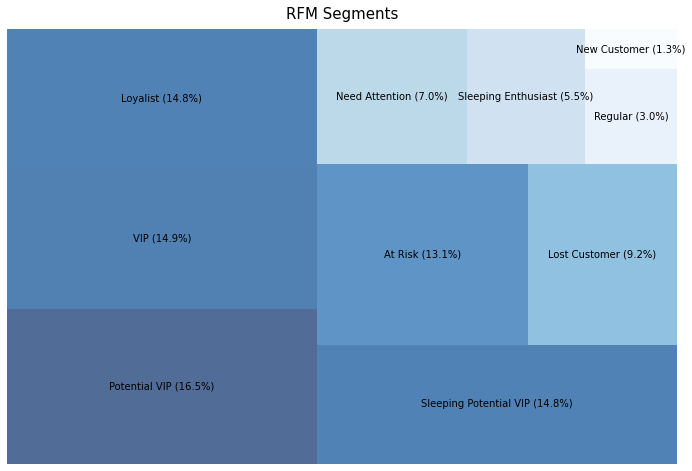

In [160]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
import matplotlib 
cmap=matplotlib.cm.Blues
# cmap = plt.cm.get_cmap('tab20')
norm=matplotlib.colors.Normalize(vmin=rfm_sum['count'].min(), vmax=rfm_sum['count'].max())
colors=[cmap(norm(i)) for i in rfm_sum['count']]
squarify.plot(sizes = rfm_sum['count'], label= rfm_sum['label'], alpha = 0.7, color = colors)
plt.axis('off')
plt.title('RFM Segments', size = 15, pad = 10);

In [161]:
# fig = plt.figure(figsize = (14,5))
# ax = plt.subplot(1,2,1)
# total = len(rfm)
# ax.bar(rfm['r_score'].value_counts().sort_values(ascending= False).index, rfm['r_score'].value_counts().sort_values(ascending= False).values, 
#         color = sns.color_palette()[0])
# def text():
#     for p in ax.patches:
#         percentage = '{:.0f}%'.format(100*p.get_height()/total)
#         x = p.get_x() + p.get_width()/3
#         y = p.get_y() + p.get_height()
#         ax.annotate(percentage, (x,y))
#     return ax
# ax = text()
# plt.xticks([1,2,3,4])
# plt.title("Recency Distribution", size = 15, pad = 10)
# plt.ylabel('Count', labelpad = 12)

# ax = plt.subplot(1,2,2)
# ax.bar(rfm['f_score'].value_counts().sort_values(ascending= False).index, rfm['f_score'].value_counts().sort_values(ascending= False).values, 
#         color = sns.color_palette()[0])
# ax = text()
# plt.xticks([1,2,3,4])
# plt.title("Frequency Distribution", size = 15,pad = 10);

### Clustering
three prerequisite of k-means clustering; 1. 같은 average value, std, var 2. not skewed

In [194]:
def remove_negative(x):
    if x <= 0:
        return 1
    else:
        return x
 
cols = ['recency', 'monetary_value', 'frequency']
for c in cols:
    rfm[c] = [remove_negative(x) for x in rfm[c]]

rfm_log = rfm[['recency', 'frequency', 'monetary_value']].apply(np.log, axis = 1)

In [195]:
scaler = StandardScaler()
scaler.fit(rfm_log)

rfm_normalized= scaler.transform(rfm_log)

rfm_normalized = pd.DataFrame(rfm_normalized, index = rfm.index, columns = rfm_log.columns)
rfm_normalized.describe()

,recency,frequency,monetary_value
count,4372.00,4372.00,4372.00
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.55,-1.12,-20.22
25%,-0.61,-1.12,-0.41
50%,0.12,0.03,0.01
75%,0.84,0.56,0.49
max,1.50,4.66,3.20


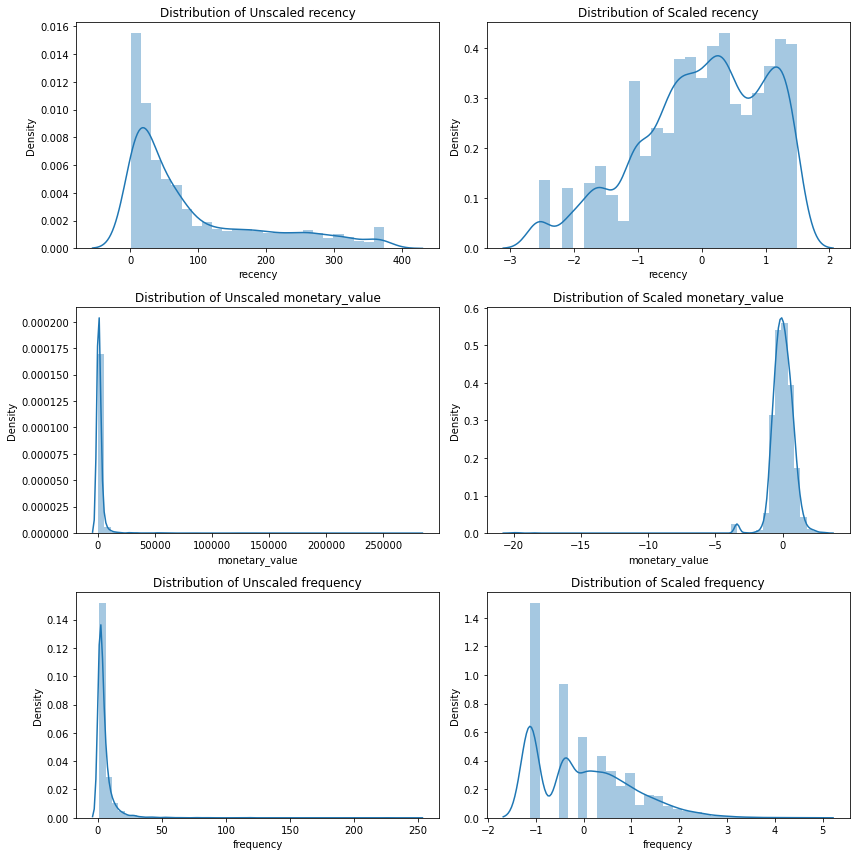

In [196]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,12))
plt.subplots_adjust(right=1.5, top=1.25)

for i, c in enumerate(cols):
    sns.distplot(rfm[c],  hist=True, ax=ax[i][0])    
    sns.distplot(rfm_normalized[c], hist=True, ax=ax[i][1])
    ax[i][0].set_title(f'Distribution of Unscaled {c}')
    ax[i][1].set_title(f'Distribution of Scaled {c}')
    
plt.tight_layout()      
plt.show()

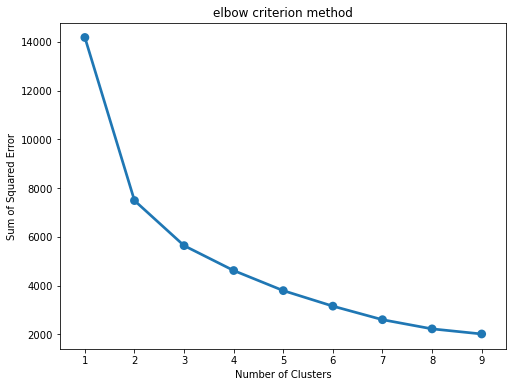

In [230]:
# choosing a number of clusters with elbow criterion method

sse = {}
for k in range (1,10):
    kmeans = KMeans(n_clusters =k, random_state = 42)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

plt.figure(figsize = (8,6))
plt.title('elbow criterion method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

# 가장 각도가 작은 포인트: 2

In [222]:
# compute k-means clustering on pre-processed data

kc = KMeans(n_clusters=2, random_state=42)
kc.fit(rfm_normalized)

# extract the clustered labels

cluster_labels = kc.labels_
rfm_copy = rfm[['recency', 'frequency','monetary_value']]
rfm_kc = rfm_copy.assign(Cluster = cluster_labels)

# analyzing average RFM values of each cluster with a raw-data

rfm_groupby = rfm_kc.groupby('Cluster').agg({'recency': 'mean','frequency': 'mean',
                                         'monetary_value': ['mean', 'count']}).round(1)
rfm_groupby

recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0         24.50      9.70        3885.80  1817
1        140.10      1.80         481.90  2555

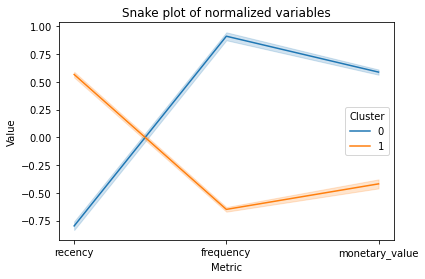

In [229]:
# build customer personas - snake plots

rfm_normalized = rfm_normalized.assign(Cluster = cluster_labels)
rfm_melt = pd.melt(rfm_normalized.reset_index(), id_vars = ['CustomerID', 'Cluster'], value_vars = ['recency', 'frequency', 'monetary_value'], var_name = 'metric',
                                                 value_name = 'value')

plt.title("Snake plot of normalized variables")
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data= rfm_melt, x='metric', y='value', hue='Cluster');

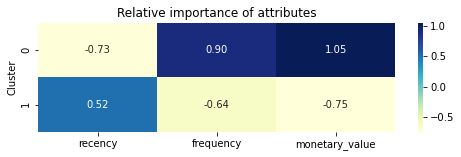

In [228]:
# relevant importance heatmap

cluster_avg = rfm_kc.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = rfm_copy.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f',cmap='YlGnBu')

### Conclusion